In [1]:
import numpy as np
import csv
import pandas as pd

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


def generate_csv(data, title, str_path):
    save_file = ""
    if(title == "actions"):
        save_file = str_path
    elif(title == "obs"):
        save_file = str_path
    
    np.savetxt(save_file, data, delimiter=",")
    all_filenames.append(save_file)
    
    with open(save_file,newline='') as f:
        r = csv.reader(f)
        row_data = [line for line in r]
        
    if(title == "actions"):
        with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                       'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                       'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                       'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
            
            w.writerows(row_data)
            return save_file
    elif(title == "obs"):
         with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                        'drink_x', 'drink_y', 'drink_z',
                        'hand_x', 'hand_y', 'hand_z', 
                        'finger_lt0', 'finger_rg0', 'finger_md0',
                        'finger_if0', 'finger_if1', 'finger_if2',
                        'finger_tb0', 'finger_tb1', 'finger_tb2'])
            
            w.writerows(row_data)
            return save_file
            
def merge_csv(obs_path, action_path, save_path):

    a = pd.read_csv(obs_path)
    b = pd.read_csv(action_path)
    result = pd.concat([a, b], axis=1)
    result.to_csv(save_path, index=False)


Using TensorFlow backend.


In [2]:
def readTrain(file_path):
    train = pd.read_csv(file_path)
    print(train)
    print(train.shape)
    return train

def augDataRow(train, timestep):
    zero_row = train.loc[0]
    final_row = train.loc[train.shape[0]-1]
    df = pd.DataFrame([zero_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                          'drink_x', 'drink_y', 'drink_z',
                                          'hand_x', 'hand_y', 'hand_z', 
                                          'finger_lt0', 'finger_rg0', 'finger_md0',
                                          'finger_if0', 'finger_if1', 'finger_if2',
                                          'finger_tb0', 'finger_tb1', 'finger_tb2',
                                          'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                          'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                          'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                          'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
                                          
    
    df_final = pd.DataFrame([final_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                                 'drink_x', 'drink_y', 'drink_z',
                                                 'hand_x', 'hand_y', 'hand_z', 
                                                 'finger_lt0', 'finger_rg0', 'finger_md0',
                                                 'finger_if0', 'finger_if1', 'finger_if2',
                                                 'finger_tb0', 'finger_tb1', 'finger_tb2',
                                                 'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                                 'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                                 'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                                 'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
    
    for i in range(timestep-1):
        train = pd.concat([df,train], ignore_index = True)
        
    for i in range(timestep-1):
        train = pd.concat([train,df_final], ignore_index = True)
        
    print(type(train))
    print(train.shape)   
    print(train)
    return train

hand_x_max_arr = []
hand_x_min_arr = []
hand_y_max_arr = []
hand_y_min_arr = []
hand_z_max_arr = []
hand_z_min_arr = []

def hand_pos(train):
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    hand_x_max_arr.append(hand_x_max)
    print("hand_x min is : " + str(hand_x_min))
    hand_x_min_arr.append(hand_x_min)
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    hand_y_max_arr.append(hand_y_max)
    print("hand_y min is : " + str(hand_y_min))
    hand_y_min_arr.append(hand_y_min)
    
     
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    hand_z_max_arr.append(hand_z_max)
    print("hand_z min is : " + str(hand_z_min))
    hand_z_min_arr.append(hand_z_min)

###for many dataset
def many_normalize(train):
    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    
    for i in range(len(hand_x_max_arr)):
        if(hand_x_max_arr[i] > hand_x_max):
            hand_x_max = hand_x_max_arr[i]
    for i in range(len(hand_x_min_arr)):
        if(hand_x_min_arr[i] < hand_x_min):
            hand_x_min = hand_x_min_arr[i]
            
    
    for i in range(len(hand_y_max_arr)):
        if(hand_y_max_arr[i] > hand_y_max):
            hand_y_max = hand_y_max_arr[i]
    for i in range(len(hand_y_min_arr)):
        if(hand_y_min_arr[i] < hand_y_min):
            hand_y_min = hand_y_min_arr[i]
            
    for i in range(len(hand_z_max_arr)):
        if(hand_z_max_arr[i] > hand_z_max):
            hand_z_max = hand_z_max_arr[i]
    for i in range(len(hand_z_min_arr)):
        if(hand_z_min_arr[i] < hand_z_min):
            hand_z_min = hand_z_min_arr[i]
            
    print("hand_x_max_arr is : " )
    print(hand_x_max_arr)
    print(hand_x_max)
    print("hand_x_min_arr is : " )
    print(hand_x_min_arr)
    print(hand_x_min)
    print("hand_y_max_arr is : " )
    print(hand_y_max_arr)
    print(hand_y_max)
    print("hand_y_min_arr is : " )
    print(hand_y_min_arr)
    print(hand_y_min)
    print("hand_z_max_arr is : " )
    print(hand_z_max_arr)
    print(hand_z_max)
    print("hand_z_min_arr is : " )
    print(hand_z_min_arr)
    print(hand_z_min)

    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     
    return train

"""
def DF_Col_Max_Min(train, column_name):
    
    max_value = -1000.0
    min_value = 1000.0
    
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] > max_value):
            max_value = train[column_name][i]
            
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] < min_value):
            min_value = train[column_name][i]
    
    return max_value, min_value
"""
###for one dataset
def normalize(train):
    #in dataset 0->8 : max_x = 0.9 min_x = 0.7 / max_y = min_y=0.82 / max_z = 0.25 min_z = 0.05 

    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
#         print(train['hand_x'][i])
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    print("hand_x min is : " + str(hand_x_min))
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    print("hand_y min is : " + str(hand_y_min))
    
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    print("hand_z min is : " + str(hand_z_min))

#     train['hand_x'] = (train['hand_x'] - train['hand_x'].min())/(train['hand_x'].max() - train['hand_x'].min())
#     train['hand_y'] = (train['hand_y'] - train['hand_y'].min())/(train['hand_y'].max() - train['hand_y'].min())
#     train['hand_z'] = (train['hand_z'] - train['hand_z'].min())/(train['hand_z'].max() - train['hand_z'].min())
      
    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     

    return train

def buildTrain_v2(train, timesteps):
    X_train, Y_train = [], []
    print(type(train))
    #original is 12 
    #plus 9 hand andgle
    train_split = np.split(train, [21], axis=1)
    X_train = train_split[0]
    Y_train = train_split[1]
    X_train_new = []
    Y_train_new = []
    
    print(Y_train)
    print(type(Y_train))
    print(Y_train.shape)
    
    timesteps = timesteps-1
    for i in range(train.shape[0] - timesteps):
#         print("now i is : " + str(i))
#         print(np.array(X_train.loc[i:i+timesteps]))
        X_train_new.append(np.array(X_train.loc[i:i+timesteps]))
    
    Y_train_new = np.array(Y_train.loc[0+timesteps:Y_train.shape[0]-1])   
              
    return np.array(X_train_new), Y_train_new


def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]


def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

def buildManyToOneModel(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

def buildManyToOneModel_expand_depth(X_train):
    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

def buildManyToOneModel_expand_depth_dropout(X_train):
    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.2))
    model.add(LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.2))
    model.add(LSTM(units = 32, recurrent_dropout = 0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

def buildManyToOneModel_expand_depth_dropout_V2(X_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 128, return_sequences = True, recurrent_initializer="orthogonal", input_shape = (X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.2)))
    model.add(Bidirectional(LSTM(units = 64, return_sequences = True, recurrent_initializer="orthogonal", recurrent_dropout = 0.2)))
    model.add(Bidirectional(LSTM(units = 32, recurrent_initializer="orthogonal", recurrent_dropout = 0.2)))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
#     model.summary()

    return model



def buildManyToOneModel_expand_depth_V2(X_train):
    model = Sequential()
    model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
#     model.summary()

    return model



def buildManyToOneModel_expand_width(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

(248, 5, 21)
(248, 16)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/500
248/248 [==============================] - 5s 22ms/step - loss: 0.0964
Epoch 2/500
248/248 [==============================] - 0s 933us/step - loss: 0.0203
Epoch 3/500
248/248 [==============================] - 0s 935us/step - loss: 0.0113
Epoch 4/500
248/248 [==============================] - 0s 905us/step - loss: 0.0077
Epoch 5/500
248/248 [==============================] - 0s 901us/step - loss: 0.0050
Epoch 6/500
248/248 [==============================] - 0s 885us/step - loss: 0.0093
Epoch 7/500
248/248 [==============================] - 0s 919us/step - loss: 0.0052
Epoch 8/500
248/248 [==============================] - 0s 883us/step - loss: 0.0052
Epoch 9/500
248/248 [==============================] - 0s 905us/step - loss: 0.0042
Epoch 1

248/248 [==============================] - 0s 905us/step - loss: 7.5648e-04
Epoch 75/500
248/248 [==============================] - 0s 877us/step - loss: 8.7383e-04
Epoch 76/500
248/248 [==============================] - 0s 921us/step - loss: 0.0013
Epoch 77/500
248/248 [==============================] - 0s 903us/step - loss: 0.0010
Epoch 78/500
248/248 [==============================] - 0s 871us/step - loss: 9.3887e-04
Epoch 79/500
248/248 [==============================] - 0s 905us/step - loss: 0.0011
Epoch 80/500
248/248 [==============================] - 0s 881us/step - loss: 7.7119e-04
Epoch 81/500
248/248 [==============================] - 0s 901us/step - loss: 5.7220e-04
Epoch 82/500
248/248 [==============================] - 0s 893us/step - loss: 0.0011
Epoch 83/500
248/248 [==============================] - 0s 907us/step - loss: 9.8392e-04
Epoch 84/500
248/248 [==============================] - 0s 869us/step - loss: 8.3266e-04
Epoch 85/500
248/248 [============================

248/248 [==============================] - 0s 1ms/step - loss: 4.7360e-04
Epoch 166/500
248/248 [==============================] - 0s 934us/step - loss: 3.2639e-04
Epoch 167/500
248/248 [==============================] - 0s 977us/step - loss: 2.8326e-04
Epoch 168/500
248/248 [==============================] - 0s 993us/step - loss: 3.6567e-04
Epoch 169/500
248/248 [==============================] - 0s 913us/step - loss: 5.3916e-04
Epoch 170/500
248/248 [==============================] - 0s 899us/step - loss: 2.2225e-04
Epoch 171/500
248/248 [==============================] - 0s 891us/step - loss: 3.0279e-04
Epoch 172/500
248/248 [==============================] - 0s 897us/step - loss: 3.3499e-04
Epoch 173/500
248/248 [==============================] - 0s 897us/step - loss: 3.2283e-04
Epoch 174/500
248/248 [==============================] - 0s 901us/step - loss: 3.5736e-04
Epoch 175/500
248/248 [==============================] - 0s 903us/step - loss: 2.9236e-04
Epoch 176/500
248/248 [===

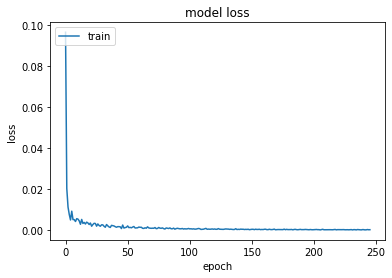

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

Epoch 1/500
253/253 [==============================] - 5s 18ms/step - loss: 0.0814
Epoch 2/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 3/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 4/500
253/253 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 5/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 6/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 7/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 8/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 9/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 10/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 11/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 12/500
253/253 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 13/500

253/253 [==============================] - 0s 2ms/step - loss: 4.3093e-04
Epoch 99/500
253/253 [==============================] - 0s 2ms/step - loss: 5.3648e-04
Epoch 100/500
253/253 [==============================] - 0s 2ms/step - loss: 5.5277e-04
Epoch 101/500
253/253 [==============================] - 0s 2ms/step - loss: 6.3128e-04
Epoch 102/500
253/253 [==============================] - 0s 2ms/step - loss: 5.3746e-04
Epoch 103/500
253/253 [==============================] - 0s 2ms/step - loss: 7.3091e-04
Epoch 104/500
253/253 [==============================] - 0s 2ms/step - loss: 4.6503e-04
Epoch 105/500
253/253 [==============================] - 0s 2ms/step - loss: 4.5625e-04
Epoch 106/500
253/253 [==============================] - 0s 2ms/step - loss: 3.7431e-04
Epoch 107/500
253/253 [==============================] - 0s 2ms/step - loss: 5.1134e-04
Epoch 108/500
253/253 [==============================] - 0s 2ms/step - loss: 7.9522e-04
Epoch 109/500
253/253 [========================

253/253 [==============================] - 0s 2ms/step - loss: 3.5988e-04
Epoch 192/500
253/253 [==============================] - 0s 2ms/step - loss: 2.7763e-04
Epoch 193/500
253/253 [==============================] - 0s 2ms/step - loss: 3.1902e-04
Epoch 194/500
253/253 [==============================] - 0s 2ms/step - loss: 2.4704e-04
Epoch 195/500
253/253 [==============================] - 0s 2ms/step - loss: 2.4452e-04
Epoch 196/500
253/253 [==============================] - 0s 2ms/step - loss: 4.3576e-04
Epoch 197/500
253/253 [==============================] - 0s 2ms/step - loss: 2.8556e-04
Epoch 198/500
253/253 [==============================] - 0s 2ms/step - loss: 2.3479e-04
Epoch 199/500
253/253 [==============================] - 0s 2ms/step - loss: 2.3549e-04
Epoch 200/500
253/253 [==============================] - 0s 2ms/step - loss: 3.6006e-04
Epoch 201/500
253/253 [==============================] - 0s 2ms/step - loss: 3.0997e-04
Epoch 202/500
253/253 [=======================

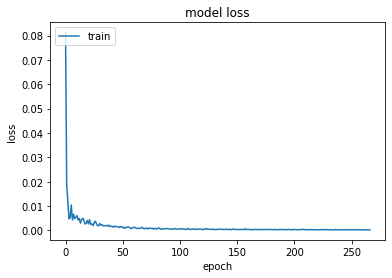

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

Epoch 1/500
263/263 [==============================] - 6s 21ms/step - loss: 0.0930
Epoch 2/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0153
Epoch 3/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0096
Epoch 4/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 5/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 6/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 7/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 8/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 9/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 10/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 11/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 12/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 13/500

263/263 [==============================] - 1s 4ms/step - loss: 4.5529e-04
Epoch 98/500
263/263 [==============================] - 1s 3ms/step - loss: 5.5204e-04
Epoch 99/500
263/263 [==============================] - 1s 3ms/step - loss: 5.0800e-04
Epoch 100/500
263/263 [==============================] - 1s 3ms/step - loss: 3.6578e-04
Epoch 101/500
263/263 [==============================] - 1s 3ms/step - loss: 6.1769e-04
Epoch 102/500
263/263 [==============================] - 1s 3ms/step - loss: 4.2259e-04
Epoch 103/500
263/263 [==============================] - 1s 3ms/step - loss: 5.2788e-04
Epoch 104/500
263/263 [==============================] - 1s 3ms/step - loss: 3.9723e-04
Epoch 105/500
263/263 [==============================] - 1s 3ms/step - loss: 4.5420e-04
Epoch 106/500
263/263 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 107/500
263/263 [==============================] - 1s 3ms/step - loss: 3.0318e-04
Epoch 108/500
263/263 [=============================

263/263 [==============================] - 1s 3ms/step - loss: 2.4122e-04
Epoch 190/500
263/263 [==============================] - 1s 3ms/step - loss: 2.3410e-04
Epoch 191/500
263/263 [==============================] - 1s 3ms/step - loss: 2.6970e-04
Epoch 192/500
263/263 [==============================] - 1s 3ms/step - loss: 1.9305e-04
Epoch 193/500
263/263 [==============================] - 1s 3ms/step - loss: 2.5285e-04
Epoch 194/500
263/263 [==============================] - 1s 3ms/step - loss: 2.4147e-04
Epoch 195/500
263/263 [==============================] - 1s 3ms/step - loss: 2.1797e-04
Epoch 196/500
263/263 [==============================] - 1s 3ms/step - loss: 2.8630e-04
Epoch 197/500
263/263 [==============================] - 1s 3ms/step - loss: 2.8592e-04
Epoch 198/500
263/263 [==============================] - 1s 4ms/step - loss: 1.8220e-04
Epoch 199/500
263/263 [==============================] - 1s 3ms/step - loss: 2.6997e-04
Epoch 200/500
263/263 [=======================

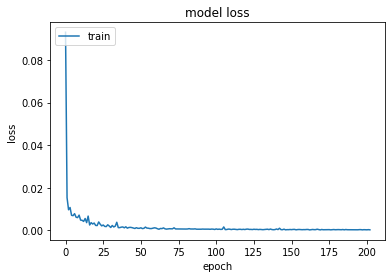

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

(273, 30, 21)
(273, 16)
Epoch 1/500
273/273 [==============================] - 6s 24ms/step - loss: 0.1024
Epoch 2/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0160
Epoch 3/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0083
Epoch 4/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 5/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 6/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0065
Epoch 7/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0080
Epoch 8/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 9/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0065
Epoch 10/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 11/500
273/273 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 12/500
273/273 [==============================] - 1s 5ms/step - l

273/273 [==============================] - 1s 5ms/step - loss: 3.7633e-04
Epoch 98/500
273/273 [==============================] - 1s 5ms/step - loss: 4.5922e-04
Epoch 99/500
273/273 [==============================] - 1s 5ms/step - loss: 5.2562e-04
Epoch 100/500
273/273 [==============================] - 1s 5ms/step - loss: 3.9620e-04
Epoch 101/500
273/273 [==============================] - 1s 5ms/step - loss: 3.6136e-04
Epoch 102/500
273/273 [==============================] - 1s 5ms/step - loss: 3.6595e-04
Epoch 103/500
273/273 [==============================] - 1s 5ms/step - loss: 3.9140e-04
Epoch 104/500
273/273 [==============================] - 1s 5ms/step - loss: 3.4532e-04
Epoch 105/500
273/273 [==============================] - 1s 5ms/step - loss: 4.1616e-04
Epoch 106/500
273/273 [==============================] - 1s 5ms/step - loss: 2.5984e-04
Epoch 107/500
273/273 [==============================] - 1s 5ms/step - loss: 4.1462e-04
Epoch 108/500
273/273 [=========================

273/273 [==============================] - 1s 5ms/step - loss: 1.7354e-04
Epoch 191/500
273/273 [==============================] - 1s 5ms/step - loss: 2.3322e-04
Epoch 192/500
273/273 [==============================] - 1s 5ms/step - loss: 1.7991e-04
Epoch 193/500
273/273 [==============================] - 1s 5ms/step - loss: 2.3536e-04
Epoch 194/500
273/273 [==============================] - 1s 5ms/step - loss: 1.2211e-04
Epoch 195/500
273/273 [==============================] - 1s 5ms/step - loss: 2.1479e-04
Epoch 196/500
273/273 [==============================] - 1s 5ms/step - loss: 2.4636e-04
Epoch 197/500
273/273 [==============================] - 1s 5ms/step - loss: 1.7159e-04
Epoch 198/500
273/273 [==============================] - 1s 5ms/step - loss: 2.8479e-04
Epoch 199/500
273/273 [==============================] - 1s 5ms/step - loss: 1.2743e-04
Epoch 200/500
273/273 [==============================] - 1s 5ms/step - loss: 1.4326e-04
Epoch 201/500
273/273 [=======================

273/273 [==============================] - 1s 5ms/step - loss: 1.5829e-04
Epoch 284/500
273/273 [==============================] - 1s 5ms/step - loss: 1.4482e-04
Epoch 285/500
273/273 [==============================] - 1s 5ms/step - loss: 1.2368e-04
Epoch 286/500
273/273 [==============================] - 1s 5ms/step - loss: 1.5719e-04
Epoch 287/500
273/273 [==============================] - 1s 5ms/step - loss: 1.4227e-04
Epoch 288/500
273/273 [==============================] - 1s 5ms/step - loss: 1.0492e-04
Epoch 289/500
273/273 [==============================] - 1s 5ms/step - loss: 1.4047e-04
Epoch 290/500
273/273 [==============================] - 1s 5ms/step - loss: 1.8693e-04
Epoch 291/500
273/273 [==============================] - 1s 5ms/step - loss: 1.6008e-04
Epoch 292/500
273/273 [==============================] - 1s 5ms/step - loss: 1.1671e-04
Epoch 293/500
273/273 [==============================] - 1s 5ms/step - loss: 1.1018e-04
Epoch 294/500
273/273 [=======================

273/273 [==============================] - 1s 5ms/step - loss: 1.2454e-04
Epoch 377/500
273/273 [==============================] - 1s 5ms/step - loss: 9.2758e-05
Epoch 378/500
273/273 [==============================] - 1s 5ms/step - loss: 7.6635e-05
Epoch 379/500
273/273 [==============================] - 1s 5ms/step - loss: 1.4019e-04
Epoch 380/500
273/273 [==============================] - 1s 5ms/step - loss: 1.0833e-04
Epoch 381/500
273/273 [==============================] - 1s 5ms/step - loss: 1.1162e-04
Epoch 382/500
273/273 [==============================] - 1s 5ms/step - loss: 7.4659e-05
Epoch 383/500
273/273 [==============================] - 1s 5ms/step - loss: 1.1524e-04
Epoch 00383: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 30, 256)           153600    
_________________________________________________________________
bidirectional_11 (

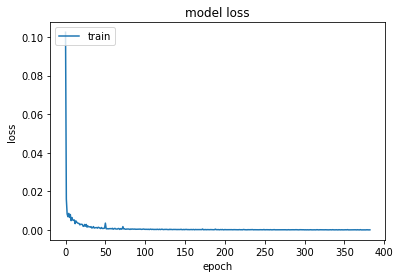

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

Epoch 1/500
283/283 [==============================] - 8s 28ms/step - loss: 0.0788
Epoch 2/500
283/283 [==============================] - 2s 6ms/step - loss: 0.0201
Epoch 3/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0095
Epoch 4/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0072
Epoch 5/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0080
Epoch 6/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0063
Epoch 7/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0101
Epoch 8/500
283/283 [==============================] - 2s 6ms/step - loss: 0.0051
Epoch 9/500
283/283 [==============================] - 2s 7ms/step - loss: 0.0055
Epoch 10/500
283/283 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 11/500
283/283 [==============================] - 2s 6ms/step - loss: 0.0052
Epoch 12/500
283/283 [==============================] - 2s 6ms/step - loss: 0.0044
Epoch 13/500

283/283 [==============================] - 2s 6ms/step - loss: 3.3579e-04
Epoch 98/500
283/283 [==============================] - 2s 6ms/step - loss: 3.9085e-04
Epoch 99/500
283/283 [==============================] - 2s 6ms/step - loss: 2.5915e-04
Epoch 100/500
283/283 [==============================] - 2s 6ms/step - loss: 3.2288e-04
Epoch 101/500
283/283 [==============================] - 2s 6ms/step - loss: 3.7232e-04
Epoch 102/500
283/283 [==============================] - 2s 6ms/step - loss: 3.6147e-04
Epoch 103/500
283/283 [==============================] - 2s 6ms/step - loss: 2.8062e-04
Epoch 104/500
283/283 [==============================] - 2s 6ms/step - loss: 4.0155e-04
Epoch 105/500
283/283 [==============================] - 2s 6ms/step - loss: 4.0344e-04
Epoch 106/500
283/283 [==============================] - 2s 6ms/step - loss: 3.1005e-04
Epoch 107/500
283/283 [==============================] - 2s 6ms/step - loss: 3.0474e-04
Epoch 108/500
283/283 [=========================

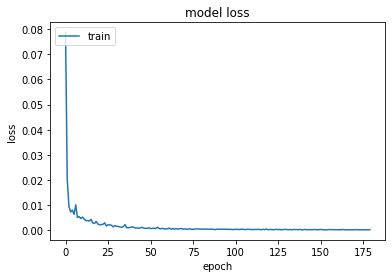

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

[342 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
(342, 16)
(293, 50, 21)
(293, 16)
Epoch 1/500
293/293 [==============================] - 9s 30ms/step - loss: 0.0830
Epoch 2/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0197
Epoch 3/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0081
Epoch 4/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0077
Epoch 5/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0085
Epoch 6/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0086
Epoch 7/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0046
Epoch 8/500
293/293 [==============================] - 2s 8ms/step - loss: 0.0060
Epoch 9/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0069
Epoch 10/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0040
Epoch 11/500
293/293 [==============================] - 2s 7ms/step - loss: 0.0037

293/293 [==============================] - 2s 7ms/step - loss: 4.2975e-04
Epoch 97/500
293/293 [==============================] - 2s 8ms/step - loss: 4.0657e-04
Epoch 98/500
293/293 [==============================] - 2s 7ms/step - loss: 3.1894e-04
Epoch 99/500
293/293 [==============================] - 2s 7ms/step - loss: 6.1932e-04
Epoch 100/500
293/293 [==============================] - 2s 7ms/step - loss: 4.1182e-04
Epoch 101/500
293/293 [==============================] - 2s 7ms/step - loss: 3.5996e-04
Epoch 102/500
293/293 [==============================] - 2s 7ms/step - loss: 3.9214e-04
Epoch 103/500
293/293 [==============================] - 2s 7ms/step - loss: 2.5849e-04
Epoch 104/500
293/293 [==============================] - 2s 8ms/step - loss: 3.2543e-04
Epoch 105/500
293/293 [==============================] - 2s 7ms/step - loss: 3.2071e-04
Epoch 106/500
293/293 [==============================] - 2s 7ms/step - loss: 3.5308e-04
Epoch 107/500
293/293 [==========================

293/293 [==============================] - 2s 7ms/step - loss: 1.6721e-04
Epoch 190/500
293/293 [==============================] - 2s 7ms/step - loss: 2.4379e-04
Epoch 191/500
293/293 [==============================] - 2s 7ms/step - loss: 1.8626e-04
Epoch 192/500
293/293 [==============================] - 2s 7ms/step - loss: 1.8163e-04
Epoch 193/500
293/293 [==============================] - 2s 7ms/step - loss: 1.8407e-04
Epoch 194/500
293/293 [==============================] - 2s 7ms/step - loss: 1.6659e-04
Epoch 195/500
293/293 [==============================] - 2s 7ms/step - loss: 1.8974e-04
Epoch 196/500
293/293 [==============================] - 2s 7ms/step - loss: 1.5337e-04
Epoch 197/500
293/293 [==============================] - 2s 7ms/step - loss: 2.2054e-04
Epoch 198/500
293/293 [==============================] - 2s 7ms/step - loss: 1.3873e-04
Epoch 199/500
293/293 [==============================] - 2s 7ms/step - loss: 1.8112e-04
Epoch 200/500
293/293 [=======================

293/293 [==============================] - 2s 8ms/step - loss: 1.0041e-04
Epoch 283/500
293/293 [==============================] - 2s 8ms/step - loss: 1.5651e-04
Epoch 284/500
293/293 [==============================] - 2s 7ms/step - loss: 1.0702e-04
Epoch 285/500
293/293 [==============================] - 2s 7ms/step - loss: 1.3268e-04
Epoch 286/500
293/293 [==============================] - 2s 7ms/step - loss: 9.8574e-05
Epoch 287/500
293/293 [==============================] - 2s 7ms/step - loss: 1.0313e-04
Epoch 288/500
293/293 [==============================] - 2s 7ms/step - loss: 1.2388e-04
Epoch 289/500
293/293 [==============================] - 2s 7ms/step - loss: 1.5972e-04
Epoch 290/500
293/293 [==============================] - 2s 8ms/step - loss: 1.1019e-04
Epoch 291/500
293/293 [==============================] - 2s 7ms/step - loss: 1.1447e-04
Epoch 292/500
293/293 [==============================] - 2s 7ms/step - loss: 1.2266e-04
Epoch 293/500
293/293 [=======================

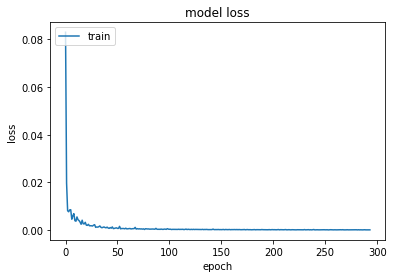

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

(303, 60, 21)
(303, 16)
Epoch 1/500
303/303 [==============================] - 10s 32ms/step - loss: 0.0735
Epoch 2/500
303/303 [==============================] - 3s 8ms/step - loss: 0.0151
Epoch 3/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0091
Epoch 4/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0089
Epoch 5/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0066
Epoch 6/500
303/303 [==============================] - 3s 8ms/step - loss: 0.0058
Epoch 7/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0075
Epoch 8/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0044
Epoch 9/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0067
Epoch 10/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0040
Epoch 11/500
303/303 [==============================] - 3s 9ms/step - loss: 0.0045
Epoch 12/500
303/303 [==============================] - 3s 9ms/step - 

303/303 [==============================] - 3s 9ms/step - loss: 3.8479e-04
Epoch 97/500
303/303 [==============================] - 3s 9ms/step - loss: 3.0774e-04
Epoch 98/500
303/303 [==============================] - 3s 9ms/step - loss: 4.4180e-04
Epoch 99/500
303/303 [==============================] - 3s 9ms/step - loss: 3.4003e-04
Epoch 100/500
303/303 [==============================] - 3s 9ms/step - loss: 3.1113e-04
Epoch 101/500
303/303 [==============================] - 3s 9ms/step - loss: 3.6856e-04
Epoch 102/500
303/303 [==============================] - 3s 9ms/step - loss: 2.7507e-04
Epoch 103/500
303/303 [==============================] - 3s 9ms/step - loss: 4.7935e-04
Epoch 104/500
303/303 [==============================] - 3s 9ms/step - loss: 3.2131e-04
Epoch 105/500
303/303 [==============================] - 3s 9ms/step - loss: 3.0993e-04
Epoch 106/500
303/303 [==============================] - 3s 9ms/step - loss: 2.9328e-04
Epoch 107/500
303/303 [==========================

303/303 [==============================] - 3s 9ms/step - loss: 2.4247e-04
Epoch 190/500
303/303 [==============================] - 3s 9ms/step - loss: 2.2242e-04
Epoch 191/500
303/303 [==============================] - 3s 8ms/step - loss: 1.6724e-04
Epoch 192/500
303/303 [==============================] - 3s 9ms/step - loss: 2.0038e-04
Epoch 193/500
303/303 [==============================] - 3s 9ms/step - loss: 1.6683e-04
Epoch 194/500
303/303 [==============================] - 3s 9ms/step - loss: 1.6936e-04
Epoch 195/500
303/303 [==============================] - 3s 9ms/step - loss: 1.6749e-04
Epoch 196/500
303/303 [==============================] - 3s 9ms/step - loss: 2.1051e-04
Epoch 197/500
303/303 [==============================] - 3s 9ms/step - loss: 1.6208e-04
Epoch 198/500
303/303 [==============================] - 3s 9ms/step - loss: 1.6053e-04
Epoch 199/500
303/303 [==============================] - 3s 9ms/step - loss: 1.8093e-04
Epoch 200/500
303/303 [=======================

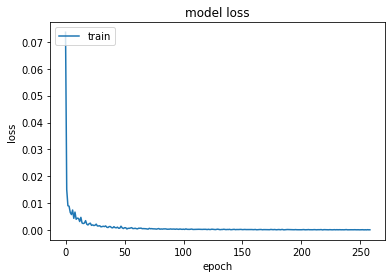

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

     act_arm_one  act_arm_two  act_arm_three  act_arm_four  act_arm_five  \
0       0.742037     0.492039       0.499966      0.031841      0.506316   
1       0.742037     0.492039       0.499966      0.031841      0.506316   
2       0.742037     0.492039       0.499966      0.031841      0.506316   
3       0.742037     0.492039       0.499966      0.031841      0.506316   
4       0.742037     0.492039       0.499966      0.031841      0.506316   
5       0.742037     0.492039       0.499966      0.031841      0.506316   
6       0.742037     0.492039       0.499966      0.031841      0.506316   
7       0.742037     0.492039       0.499966      0.031841      0.506316   
8       0.742037     0.492039       0.499966      0.031841      0.506316   
9       0.742037     0.492039       0.499966      0.031841      0.506316   
10      0.742037     0.492039       0.499966      0.031841      0.506316   
11      0.742037     0.492039       0.499966      0.031841      0.506316   
12      0.74

Epoch 1/500
313/313 [==============================] - 11s 35ms/step - loss: 0.0747
Epoch 2/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0132
Epoch 3/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0125
Epoch 4/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0078
Epoch 5/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0086
Epoch 6/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0068
Epoch 7/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0066
Epoch 8/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0053
Epoch 9/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0074
Epoch 10/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 11/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 12/500
313/313 [==============================] - 3s 10ms/step - loss: 0.0040


313/313 [==============================] - 3s 10ms/step - loss: 3.8721e-04
Epoch 97/500
313/313 [==============================] - 3s 10ms/step - loss: 4.0345e-04
Epoch 98/500
313/313 [==============================] - 3s 10ms/step - loss: 4.0964e-04
Epoch 99/500
313/313 [==============================] - 3s 10ms/step - loss: 4.1684e-04
Epoch 100/500
313/313 [==============================] - 3s 10ms/step - loss: 3.9848e-04
Epoch 101/500
313/313 [==============================] - 3s 10ms/step - loss: 3.0357e-04
Epoch 102/500
313/313 [==============================] - 3s 10ms/step - loss: 4.8277e-04
Epoch 103/500
313/313 [==============================] - 3s 10ms/step - loss: 3.1605e-04
Epoch 104/500
313/313 [==============================] - 3s 10ms/step - loss: 3.3262e-04
Epoch 105/500
313/313 [==============================] - 3s 10ms/step - loss: 4.1043e-04
Epoch 106/500
313/313 [==============================] - 3s 10ms/step - loss: 2.8222e-04
Epoch 107/500
313/313 [===============

313/313 [==============================] - 3s 10ms/step - loss: 1.8582e-04
Epoch 189/500
313/313 [==============================] - 3s 10ms/step - loss: 2.4604e-04
Epoch 190/500
313/313 [==============================] - 3s 10ms/step - loss: 2.1885e-04
Epoch 191/500
313/313 [==============================] - 3s 10ms/step - loss: 2.3939e-04
Epoch 192/500
313/313 [==============================] - 3s 10ms/step - loss: 1.6220e-04
Epoch 193/500
313/313 [==============================] - 3s 10ms/step - loss: 2.2566e-04
Epoch 194/500
313/313 [==============================] - 3s 10ms/step - loss: 1.3155e-04
Epoch 195/500
313/313 [==============================] - 3s 10ms/step - loss: 2.2393e-04
Epoch 196/500
313/313 [==============================] - 3s 10ms/step - loss: 2.6489e-04
Epoch 197/500
313/313 [==============================] - 3s 10ms/step - loss: 1.7041e-04
Epoch 198/500
313/313 [==============================] - 3s 10ms/step - loss: 1.9671e-04
Epoch 199/500
313/313 [============

313/313 [==============================] - 3s 10ms/step - loss: 1.2449e-04
Epoch 281/500
313/313 [==============================] - 3s 10ms/step - loss: 1.2196e-04
Epoch 282/500
313/313 [==============================] - 3s 10ms/step - loss: 1.4799e-04
Epoch 283/500
313/313 [==============================] - 3s 10ms/step - loss: 1.3399e-04
Epoch 284/500
313/313 [==============================] - 3s 10ms/step - loss: 2.1195e-04
Epoch 285/500
313/313 [==============================] - 3s 10ms/step - loss: 1.2543e-04
Epoch 286/500
313/313 [==============================] - 3s 10ms/step - loss: 8.9025e-05
Epoch 287/500
313/313 [==============================] - 3s 10ms/step - loss: 1.5798e-04
Epoch 288/500
313/313 [==============================] - 3s 10ms/step - loss: 1.3397e-04
Epoch 289/500
313/313 [==============================] - 3s 10ms/step - loss: 1.6276e-04
Epoch 290/500
313/313 [==============================] - 3s 10ms/step - loss: 1.2261e-04
Epoch 291/500
313/313 [============

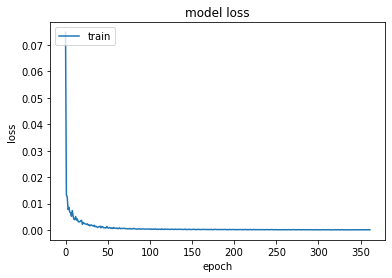

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

     act_arm_one  act_arm_two  act_arm_three  act_arm_four  act_arm_five  \
0       0.742037     0.492039       0.499966      0.031841      0.506316   
1       0.742037     0.492039       0.499966      0.031841      0.506316   
2       0.742037     0.492039       0.499966      0.031841      0.506316   
3       0.742037     0.492039       0.499966      0.031841      0.506316   
4       0.742037     0.492039       0.499966      0.031841      0.506316   
5       0.742037     0.492039       0.499966      0.031841      0.506316   
6       0.742037     0.492039       0.499966      0.031841      0.506316   
7       0.742037     0.492039       0.499966      0.031841      0.506316   
8       0.742037     0.492039       0.499966      0.031841      0.506316   
9       0.742037     0.492039       0.499966      0.031841      0.506316   
10      0.742037     0.492039       0.499966      0.031841      0.506316   
11      0.742037     0.492039       0.499966      0.031841      0.506316   
12      0.74

Epoch 1/500
323/323 [==============================] - 13s 40ms/step - loss: 0.0813
Epoch 2/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0113
Epoch 3/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0128
Epoch 4/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0061
Epoch 5/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0080
Epoch 6/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0060
Epoch 7/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0067
Epoch 8/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0055
Epoch 9/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0055
Epoch 10/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0038
Epoch 11/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0063
Epoch 12/500
323/323 [==============================] - 4s 13ms/step - loss: 0.0035


323/323 [==============================] - 4s 13ms/step - loss: 4.2486e-04
Epoch 97/500
323/323 [==============================] - 4s 13ms/step - loss: 4.4923e-04
Epoch 98/500
323/323 [==============================] - 4s 13ms/step - loss: 3.0142e-04
Epoch 99/500
323/323 [==============================] - 4s 13ms/step - loss: 4.5492e-04
Epoch 100/500
323/323 [==============================] - 4s 13ms/step - loss: 5.4646e-04
Epoch 101/500
323/323 [==============================] - 4s 13ms/step - loss: 3.2985e-04
Epoch 102/500
323/323 [==============================] - 4s 13ms/step - loss: 4.1584e-04
Epoch 103/500
323/323 [==============================] - 4s 13ms/step - loss: 3.9409e-04
Epoch 104/500
323/323 [==============================] - 4s 13ms/step - loss: 3.1575e-04
Epoch 105/500
323/323 [==============================] - 4s 14ms/step - loss: 4.3214e-04
Epoch 106/500
323/323 [==============================] - 4s 13ms/step - loss: 4.1902e-04
Epoch 107/500
323/323 [===============

323/323 [==============================] - 4s 13ms/step - loss: 2.2980e-04
Epoch 189/500
323/323 [==============================] - 4s 13ms/step - loss: 1.3032e-04
Epoch 190/500
323/323 [==============================] - 4s 13ms/step - loss: 2.2936e-04
Epoch 191/500
323/323 [==============================] - 4s 13ms/step - loss: 1.8646e-04
Epoch 192/500
323/323 [==============================] - 4s 13ms/step - loss: 2.0121e-04
Epoch 193/500
323/323 [==============================] - 4s 13ms/step - loss: 1.6823e-04
Epoch 194/500
323/323 [==============================] - 4s 13ms/step - loss: 2.1598e-04
Epoch 195/500
323/323 [==============================] - 4s 13ms/step - loss: 3.7299e-04
Epoch 196/500
323/323 [==============================] - 4s 13ms/step - loss: 2.0179e-04
Epoch 197/500
323/323 [==============================] - 4s 13ms/step - loss: 1.3742e-04
Epoch 198/500
323/323 [==============================] - 4s 13ms/step - loss: 1.6258e-04
Epoch 199/500
323/323 [============

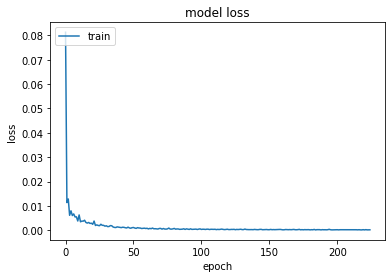

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

hand_z max is : 0.32681134150392205
hand_z min is : 0.03559783455876968
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.50

Epoch 1/500
333/333 [==============================] - 14s 43ms/step - loss: 0.0763
Epoch 2/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0118
Epoch 3/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0084
Epoch 4/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0063
Epoch 5/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0071
Epoch 6/500
333/333 [==============================] - 5s 15ms/step - loss: 0.0056
Epoch 7/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0043
Epoch 8/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0057
Epoch 9/500
333/333 [==============================] - 5s 15ms/step - loss: 0.0050
Epoch 10/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0037
Epoch 11/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0044
Epoch 12/500
333/333 [==============================] - 5s 14ms/step - loss: 0.0029


333/333 [==============================] - 5s 16ms/step - loss: 2.2830e-04
Epoch 97/500
333/333 [==============================] - 5s 14ms/step - loss: 2.3969e-04
Epoch 98/500
333/333 [==============================] - 5s 14ms/step - loss: 3.2285e-04
Epoch 99/500
333/333 [==============================] - 5s 15ms/step - loss: 3.5998e-04
Epoch 100/500
333/333 [==============================] - 5s 15ms/step - loss: 3.6580e-04
Epoch 101/500
333/333 [==============================] - 5s 14ms/step - loss: 2.3749e-04
Epoch 102/500
333/333 [==============================] - 5s 15ms/step - loss: 3.1552e-04
Epoch 103/500
333/333 [==============================] - 5s 14ms/step - loss: 2.5408e-04
Epoch 104/500
333/333 [==============================] - 5s 14ms/step - loss: 2.4887e-04
Epoch 105/500
333/333 [==============================] - 5s 14ms/step - loss: 3.1555e-04
Epoch 106/500
333/333 [==============================] - 5s 15ms/step - loss: 2.9224e-04
Epoch 107/500
333/333 [===============

333/333 [==============================] - 5s 14ms/step - loss: 1.7018e-04
Epoch 189/500
333/333 [==============================] - 5s 15ms/step - loss: 1.8542e-04
Epoch 190/500
333/333 [==============================] - 5s 14ms/step - loss: 1.1690e-04
Epoch 191/500
333/333 [==============================] - 5s 14ms/step - loss: 1.5947e-04
Epoch 192/500
333/333 [==============================] - 5s 15ms/step - loss: 1.1865e-04
Epoch 193/500
333/333 [==============================] - 5s 14ms/step - loss: 1.4357e-04
Epoch 194/500
333/333 [==============================] - 5s 14ms/step - loss: 2.0486e-04
Epoch 195/500
333/333 [==============================] - 5s 15ms/step - loss: 1.4700e-04
Epoch 196/500
333/333 [==============================] - 5s 14ms/step - loss: 1.1126e-04
Epoch 197/500
333/333 [==============================] - 5s 14ms/step - loss: 1.5861e-04
Epoch 198/500
333/333 [==============================] - 5s 14ms/step - loss: 1.9370e-04
Epoch 199/500
333/333 [============

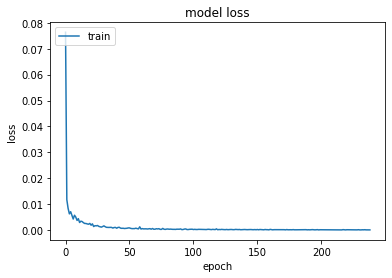

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

hand_x max is : 0.9519686862939399
hand_x min is : 0.7709310666100495
hand_y max is : 1.0723921154889355
hand_y min is : 0.7854067449599101
hand_z max is : 0.32681134150392205
hand_z min is : 0.03559783455876968
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009

Epoch 1/500
343/343 [==============================] - 16s 46ms/step - loss: 0.0767
Epoch 2/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0113
Epoch 3/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0098
Epoch 4/500
343/343 [==============================] - 5s 16ms/step - loss: 0.0062
Epoch 5/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0061
Epoch 6/500
343/343 [==============================] - 5s 16ms/step - loss: 0.0072
Epoch 7/500
343/343 [==============================] - 5s 16ms/step - loss: 0.0049
Epoch 8/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0048
Epoch 9/500
343/343 [==============================] - 5s 16ms/step - loss: 0.0050
Epoch 10/500
343/343 [==============================] - 5s 16ms/step - loss: 0.0038
Epoch 11/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0035
Epoch 12/500
343/343 [==============================] - 5s 15ms/step - loss: 0.0032


343/343 [==============================] - 5s 16ms/step - loss: 3.6865e-04
Epoch 96/500
343/343 [==============================] - 5s 15ms/step - loss: 3.5569e-04
Epoch 97/500
343/343 [==============================] - 5s 16ms/step - loss: 2.8148e-04
Epoch 98/500
343/343 [==============================] - 5s 15ms/step - loss: 3.1561e-04
Epoch 99/500
343/343 [==============================] - 5s 15ms/step - loss: 3.2509e-04
Epoch 100/500
343/343 [==============================] - 5s 16ms/step - loss: 3.4807e-04
Epoch 101/500
343/343 [==============================] - 5s 15ms/step - loss: 3.0558e-04
Epoch 102/500
343/343 [==============================] - 5s 15ms/step - loss: 3.4108e-04
Epoch 103/500
343/343 [==============================] - 6s 16ms/step - loss: 2.5864e-04
Epoch 104/500
343/343 [==============================] - 5s 15ms/step - loss: 3.1428e-04
Epoch 105/500
343/343 [==============================] - 5s 15ms/step - loss: 7.4559e-04
Epoch 106/500
343/343 [================

343/343 [==============================] - 5s 15ms/step - loss: 1.6267e-04
Epoch 188/500
343/343 [==============================] - 5s 15ms/step - loss: 2.2132e-04
Epoch 189/500
343/343 [==============================] - 5s 16ms/step - loss: 2.0008e-04
Epoch 190/500
343/343 [==============================] - 5s 15ms/step - loss: 1.1943e-04
Epoch 191/500
343/343 [==============================] - 5s 15ms/step - loss: 1.7003e-04
Epoch 192/500
343/343 [==============================] - 5s 16ms/step - loss: 1.5575e-04
Epoch 193/500
343/343 [==============================] - 5s 15ms/step - loss: 1.8106e-04
Epoch 194/500
343/343 [==============================] - 5s 15ms/step - loss: 1.5618e-04
Epoch 195/500
343/343 [==============================] - 5s 16ms/step - loss: 1.7530e-04
Epoch 196/500
343/343 [==============================] - 5s 15ms/step - loss: 1.7656e-04
Epoch 197/500
343/343 [==============================] - 5s 15ms/step - loss: 1.5101e-04
Epoch 198/500
343/343 [============

343/343 [==============================] - 5s 16ms/step - loss: 1.2584e-04
Epoch 280/500
343/343 [==============================] - 5s 15ms/step - loss: 1.2161e-04
Epoch 281/500
343/343 [==============================] - 5s 16ms/step - loss: 1.4298e-04
Epoch 282/500
343/343 [==============================] - 5s 15ms/step - loss: 9.8878e-05
Epoch 283/500
343/343 [==============================] - 5s 15ms/step - loss: 1.1068e-04
Epoch 284/500
343/343 [==============================] - 5s 16ms/step - loss: 1.2249e-04
Epoch 285/500
343/343 [==============================] - 5s 15ms/step - loss: 1.4117e-04
Epoch 286/500
343/343 [==============================] - 5s 15ms/step - loss: 9.8162e-05
Epoch 287/500
343/343 [==============================] - 5s 16ms/step - loss: 1.2161e-04
Epoch 288/500
343/343 [==============================] - 5s 15ms/step - loss: 1.0846e-04
Epoch 289/500
343/343 [==============================] - 5s 15ms/step - loss: 1.1039e-04
Epoch 290/500
343/343 [============

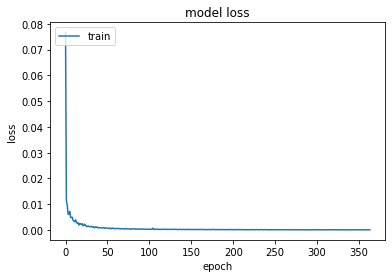

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
12   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.50

Epoch 1/500
353/353 [==============================] - 17s 48ms/step - loss: 0.0728
Epoch 2/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0148
Epoch 3/500
353/353 [==============================] - 6s 16ms/step - loss: 0.0091
Epoch 4/500
353/353 [==============================] - 6s 16ms/step - loss: 0.0059
Epoch 5/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0079
Epoch 6/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0061
Epoch 7/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0056
Epoch 8/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0041
Epoch 9/500
353/353 [==============================] - 6s 16ms/step - loss: 0.0048
Epoch 10/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0038
Epoch 11/500
353/353 [==============================] - 6s 17ms/step - loss: 0.0038
Epoch 12/500
353/353 [==============================] - 6s 16ms/step - loss: 0.0029


353/353 [==============================] - 6s 17ms/step - loss: 3.2284e-04
Epoch 96/500
353/353 [==============================] - 6s 17ms/step - loss: 4.0397e-04
Epoch 97/500
353/353 [==============================] - 6s 17ms/step - loss: 3.9685e-04
Epoch 98/500
353/353 [==============================] - 6s 17ms/step - loss: 2.9841e-04
Epoch 99/500
353/353 [==============================] - 6s 17ms/step - loss: 2.3797e-04
Epoch 100/500
353/353 [==============================] - 6s 17ms/step - loss: 3.8923e-04
Epoch 101/500
353/353 [==============================] - 6s 17ms/step - loss: 3.4259e-04
Epoch 102/500
353/353 [==============================] - 6s 16ms/step - loss: 2.4415e-04
Epoch 103/500
353/353 [==============================] - 6s 16ms/step - loss: 2.7119e-04
Epoch 104/500
353/353 [==============================] - 6s 16ms/step - loss: 3.2179e-04
Epoch 105/500
353/353 [==============================] - 6s 17ms/step - loss: 2.3593e-04
Epoch 106/500
353/353 [================

353/353 [==============================] - 6s 17ms/step - loss: 1.8975e-04
Epoch 188/500
353/353 [==============================] - 6s 17ms/step - loss: 2.6279e-04
Epoch 189/500
353/353 [==============================] - 6s 17ms/step - loss: 1.5032e-04
Epoch 190/500
353/353 [==============================] - 6s 17ms/step - loss: 1.9735e-04
Epoch 191/500
353/353 [==============================] - 6s 17ms/step - loss: 1.6641e-04
Epoch 192/500
353/353 [==============================] - 6s 17ms/step - loss: 1.6415e-04
Epoch 193/500
353/353 [==============================] - 6s 17ms/step - loss: 1.7801e-04
Epoch 194/500
353/353 [==============================] - 6s 16ms/step - loss: 1.5597e-04
Epoch 195/500
353/353 [==============================] - 7s 19ms/step - loss: 1.9766e-04
Epoch 196/500
353/353 [==============================] - 6s 18ms/step - loss: 1.6743e-04
Epoch 197/500
353/353 [==============================] - 6s 18ms/step - loss: 1.7063e-04
Epoch 198/500
353/353 [============

353/353 [==============================] - 6s 16ms/step - loss: 9.8035e-05
Epoch 280/500
353/353 [==============================] - 6s 16ms/step - loss: 1.4057e-04
Epoch 281/500
353/353 [==============================] - 6s 16ms/step - loss: 1.5970e-04
Epoch 282/500
353/353 [==============================] - 6s 16ms/step - loss: 1.2357e-04
Epoch 283/500
353/353 [==============================] - 6s 16ms/step - loss: 1.1822e-04
Epoch 284/500
353/353 [==============================] - 6s 16ms/step - loss: 1.7669e-04
Epoch 285/500
353/353 [==============================] - 6s 16ms/step - loss: 1.0022e-04
Epoch 286/500
353/353 [==============================] - 6s 16ms/step - loss: 9.4276e-05
Epoch 287/500
353/353 [==============================] - 6s 16ms/step - loss: 9.8408e-05
Epoch 288/500
353/353 [==============================] - 6s 16ms/step - loss: 1.2122e-04
Epoch 289/500
353/353 [==============================] - 6s 16ms/step - loss: 1.4457e-04
Epoch 290/500
353/353 [============

353/353 [==============================] - 6s 16ms/step - loss: 8.1458e-05
Epoch 372/500
353/353 [==============================] - 6s 16ms/step - loss: 1.1184e-04
Epoch 373/500
353/353 [==============================] - 6s 16ms/step - loss: 1.0725e-04
Epoch 374/500
353/353 [==============================] - 6s 16ms/step - loss: 9.5525e-05
Epoch 00374: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 110, 256)          153600    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 110, 128)          164352    
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
Total params: 360,208
Trainable para

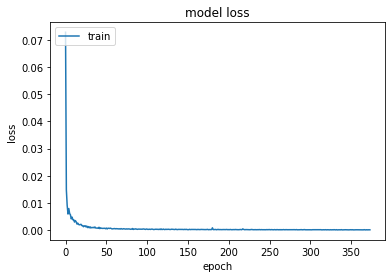

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
12   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.50

Epoch 1/500
363/363 [==============================] - 18s 48ms/step - loss: 0.0791
Epoch 2/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0118
Epoch 3/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0086
Epoch 4/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0069
Epoch 5/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0082
Epoch 6/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0059
Epoch 7/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0070
Epoch 8/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0048
Epoch 9/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0040
Epoch 10/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0046
Epoch 11/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0039
Epoch 12/500
363/363 [==============================] - 6s 17ms/step - loss: 0.0035


363/363 [==============================] - 6s 17ms/step - loss: 3.8311e-04
Epoch 96/500
363/363 [==============================] - 6s 17ms/step - loss: 2.7024e-04
Epoch 97/500
363/363 [==============================] - 6s 17ms/step - loss: 4.2916e-04
Epoch 98/500
363/363 [==============================] - 6s 17ms/step - loss: 4.3041e-04
Epoch 99/500
363/363 [==============================] - 6s 17ms/step - loss: 3.6810e-04
Epoch 100/500
363/363 [==============================] - 6s 18ms/step - loss: 3.3919e-04
Epoch 101/500
363/363 [==============================] - 6s 17ms/step - loss: 3.3691e-04
Epoch 102/500
363/363 [==============================] - 6s 17ms/step - loss: 4.2150e-04
Epoch 103/500
363/363 [==============================] - 6s 17ms/step - loss: 3.1562e-04
Epoch 104/500
363/363 [==============================] - 6s 17ms/step - loss: 3.8339e-04
Epoch 105/500
363/363 [==============================] - 6s 17ms/step - loss: 3.3232e-04
Epoch 106/500
363/363 [================

363/363 [==============================] - 6s 17ms/step - loss: 1.9640e-04
Epoch 188/500
363/363 [==============================] - 6s 17ms/step - loss: 1.9053e-04
Epoch 189/500
363/363 [==============================] - 6s 17ms/step - loss: 2.1494e-04
Epoch 190/500
363/363 [==============================] - 6s 17ms/step - loss: 1.9934e-04
Epoch 191/500
363/363 [==============================] - 6s 17ms/step - loss: 1.7812e-04
Epoch 192/500
363/363 [==============================] - 6s 17ms/step - loss: 1.5196e-04
Epoch 193/500
363/363 [==============================] - 6s 17ms/step - loss: 2.3517e-04
Epoch 194/500
363/363 [==============================] - 6s 17ms/step - loss: 1.8765e-04
Epoch 195/500
363/363 [==============================] - 6s 17ms/step - loss: 1.4642e-04
Epoch 196/500
363/363 [==============================] - 6s 17ms/step - loss: 2.1707e-04
Epoch 197/500
363/363 [==============================] - 6s 17ms/step - loss: 1.7901e-04
Epoch 198/500
363/363 [============

363/363 [==============================] - 6s 17ms/step - loss: 1.3337e-04
Epoch 280/500
363/363 [==============================] - 6s 17ms/step - loss: 1.1756e-04
Epoch 281/500
363/363 [==============================] - 6s 17ms/step - loss: 1.4314e-04
Epoch 282/500
363/363 [==============================] - 6s 17ms/step - loss: 1.2137e-04
Epoch 283/500
363/363 [==============================] - 6s 18ms/step - loss: 1.1701e-04
Epoch 284/500
363/363 [==============================] - 6s 17ms/step - loss: 1.6241e-04
Epoch 285/500
363/363 [==============================] - 6s 17ms/step - loss: 1.1104e-04
Epoch 286/500
363/363 [==============================] - 6s 17ms/step - loss: 1.3958e-04
Epoch 287/500
363/363 [==============================] - 6s 17ms/step - loss: 1.4645e-04
Epoch 288/500
363/363 [==============================] - 6s 17ms/step - loss: 6.8666e-05
Epoch 289/500
363/363 [==============================] - 6s 17ms/step - loss: 1.5478e-04
Epoch 290/500
363/363 [============

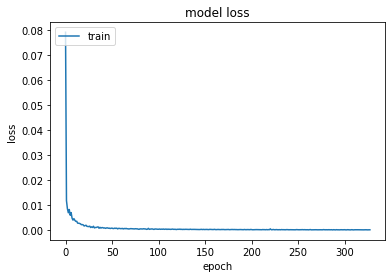

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

<class 'pandas.core.frame.DataFrame'>
(502, 38)
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
12   0.749999  0

Epoch 1/500
373/373 [==============================] - 19s 51ms/step - loss: 0.0658
Epoch 2/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0146
Epoch 3/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0063
Epoch 4/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0081
Epoch 5/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0063
Epoch 6/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0057
Epoch 7/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0063
Epoch 8/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0047
Epoch 9/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0044
Epoch 10/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0044
Epoch 11/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0035
Epoch 12/500
373/373 [==============================] - 7s 18ms/step - loss: 0.0037


373/373 [==============================] - 7s 18ms/step - loss: 1.9810e-04
Epoch 96/500
373/373 [==============================] - 7s 18ms/step - loss: 2.9383e-04
Epoch 97/500
373/373 [==============================] - 7s 18ms/step - loss: 2.5098e-04
Epoch 98/500
373/373 [==============================] - 7s 18ms/step - loss: 1.9123e-04
Epoch 99/500
373/373 [==============================] - 7s 18ms/step - loss: 3.2616e-04
Epoch 100/500
373/373 [==============================] - 7s 18ms/step - loss: 2.2895e-04
Epoch 101/500
373/373 [==============================] - 7s 18ms/step - loss: 2.5033e-04
Epoch 102/500
373/373 [==============================] - 7s 18ms/step - loss: 2.3151e-04
Epoch 103/500
373/373 [==============================] - 7s 18ms/step - loss: 2.2465e-04
Epoch 104/500
373/373 [==============================] - 7s 18ms/step - loss: 2.2899e-04
Epoch 105/500
373/373 [==============================] - 7s 18ms/step - loss: 1.9967e-04
Epoch 106/500
373/373 [================

373/373 [==============================] - 7s 18ms/step - loss: 1.3685e-04
Epoch 188/500
373/373 [==============================] - 7s 18ms/step - loss: 1.5281e-04
Epoch 189/500
373/373 [==============================] - 7s 18ms/step - loss: 1.3904e-04
Epoch 190/500
373/373 [==============================] - 7s 18ms/step - loss: 1.3966e-04
Epoch 191/500
373/373 [==============================] - 7s 18ms/step - loss: 9.5865e-05
Epoch 192/500
373/373 [==============================] - 7s 18ms/step - loss: 1.6507e-04
Epoch 193/500
373/373 [==============================] - 7s 18ms/step - loss: 1.0581e-04
Epoch 194/500
373/373 [==============================] - 7s 18ms/step - loss: 1.4053e-04
Epoch 195/500
373/373 [==============================] - 7s 18ms/step - loss: 1.2080e-04
Epoch 196/500
373/373 [==============================] - 7s 18ms/step - loss: 1.3138e-04
Epoch 197/500
373/373 [==============================] - 7s 18ms/step - loss: 1.3092e-04
Epoch 198/500
373/373 [============

373/373 [==============================] - 7s 18ms/step - loss: 1.2051e-04
Epoch 280/500
373/373 [==============================] - 7s 18ms/step - loss: 9.2227e-05
Epoch 281/500
373/373 [==============================] - 7s 18ms/step - loss: 7.9658e-05
Epoch 282/500
373/373 [==============================] - 7s 18ms/step - loss: 7.7853e-05
Epoch 283/500
373/373 [==============================] - 7s 18ms/step - loss: 8.8839e-05
Epoch 284/500
373/373 [==============================] - 7s 18ms/step - loss: 8.2430e-05
Epoch 285/500
373/373 [==============================] - 7s 18ms/step - loss: 1.1419e-04
Epoch 286/500
373/373 [==============================] - 7s 18ms/step - loss: 7.9226e-05
Epoch 287/500
373/373 [==============================] - 7s 18ms/step - loss: 8.3180e-05
Epoch 288/500
373/373 [==============================] - 7s 18ms/step - loss: 6.6156e-05
Epoch 289/500
373/373 [==============================] - 7s 18ms/step - loss: 1.0977e-04
Epoch 290/500
373/373 [============

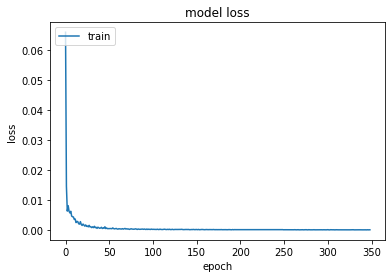

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

<class 'pandas.core.frame.DataFrame'>
(522, 38)
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
12   0.749999  0

Epoch 1/500
383/383 [==============================] - 20s 54ms/step - loss: 0.0764
Epoch 2/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0120
Epoch 3/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0071
Epoch 4/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0091
Epoch 5/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0068
Epoch 6/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0057
Epoch 7/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0056
Epoch 8/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0059
Epoch 9/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0037
Epoch 10/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0050
Epoch 11/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0035
Epoch 12/500
383/383 [==============================] - 7s 19ms/step - loss: 0.0032


383/383 [==============================] - 7s 19ms/step - loss: 4.3880e-04
Epoch 96/500
383/383 [==============================] - 7s 19ms/step - loss: 1.9989e-04
Epoch 97/500
383/383 [==============================] - 7s 19ms/step - loss: 2.5684e-04
Epoch 98/500
383/383 [==============================] - 7s 19ms/step - loss: 3.2877e-04
Epoch 99/500
383/383 [==============================] - 7s 19ms/step - loss: 2.8346e-04
Epoch 100/500
383/383 [==============================] - 7s 19ms/step - loss: 2.2213e-04
Epoch 101/500
383/383 [==============================] - 7s 19ms/step - loss: 2.5566e-04
Epoch 102/500
383/383 [==============================] - 7s 19ms/step - loss: 3.0807e-04
Epoch 103/500
383/383 [==============================] - 7s 19ms/step - loss: 2.9596e-04
Epoch 104/500
383/383 [==============================] - 7s 19ms/step - loss: 2.6892e-04
Epoch 105/500
383/383 [==============================] - 7s 19ms/step - loss: 2.7624e-04
Epoch 106/500
383/383 [================

383/383 [==============================] - 7s 19ms/step - loss: 2.0514e-04
Epoch 188/500
383/383 [==============================] - 7s 19ms/step - loss: 1.2885e-04
Epoch 189/500
383/383 [==============================] - 7s 19ms/step - loss: 1.4170e-04
Epoch 190/500
383/383 [==============================] - 7s 19ms/step - loss: 1.9429e-04
Epoch 191/500
383/383 [==============================] - 7s 19ms/step - loss: 1.4781e-04
Epoch 192/500
383/383 [==============================] - 7s 19ms/step - loss: 1.4787e-04
Epoch 193/500
383/383 [==============================] - 7s 19ms/step - loss: 1.4669e-04
Epoch 194/500
383/383 [==============================] - 7s 19ms/step - loss: 1.5776e-04
Epoch 195/500
383/383 [==============================] - 7s 19ms/step - loss: 1.4393e-04
Epoch 196/500
383/383 [==============================] - 7s 19ms/step - loss: 1.3789e-04
Epoch 197/500
383/383 [==============================] - 7s 19ms/step - loss: 1.5566e-04
Epoch 198/500
383/383 [============

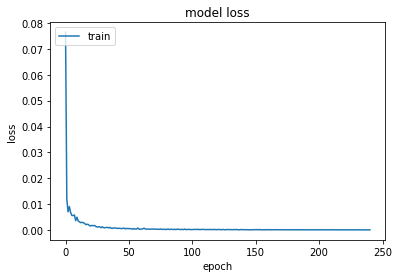

datasets_full_trag/actions/2_actions.csv
datasets_full_trag/obs/2_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.742037  0.492039   0.499966  3.184137e-02  0.506316  0.506056   
2    0.734075  0.485676   0.497765  6.368458e-02  0.502998  0.510988   
3    0.726113  0.483683   0.497748  9.552894e-02  0.498530  0.512220   
4    0.718151  0.484741   0.499560  1.273729e-01  0.498739  0.518387   
5    0.710188  0.487095   0.498985  1.592169e-01  0.506621  0.522537   
6    0.702226  0.488889   0.497279  1.910612e-01  0.512793  0.509352   
7    0.694264  0.490819   0.495766  2.229056e-01  0.512986  0.499797   
8    0.686302  0.492088   0.494433  2.547502e-01  0.514480  0.499410   
9    0.678339  0.493276   0.494233  2.865947e-01  0.516338  0.498896   
10   0.670377  0.494064   0.493489  3.184392e-01  0.516793  0.498412   
11   0.662415  0.495571   0.494070  3.502836e-01  0.517060  0.

<class 'pandas.core.frame.DataFrame'>
(542, 38)
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
2    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
3    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
4    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
5    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
6    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
7    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
8    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
9    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
10   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
11   0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
12   0.749999  0

Epoch 1/500
393/393 [==============================] - 24s 60ms/step - loss: 0.0752
Epoch 2/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0112
Epoch 3/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0072
Epoch 4/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0074
Epoch 5/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0058
Epoch 6/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0053
Epoch 7/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0067
Epoch 8/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0046
Epoch 9/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0039
Epoch 10/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0042
Epoch 11/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0032
Epoch 12/500
393/393 [==============================] - 9s 23ms/step - loss: 0.0032


393/393 [==============================] - 9s 23ms/step - loss: 2.6152e-04
Epoch 96/500
393/393 [==============================] - 9s 23ms/step - loss: 3.2247e-04
Epoch 97/500
393/393 [==============================] - 9s 23ms/step - loss: 3.8143e-04
Epoch 98/500
393/393 [==============================] - 9s 23ms/step - loss: 2.0440e-04
Epoch 99/500
393/393 [==============================] - 9s 23ms/step - loss: 3.8655e-04
Epoch 100/500
393/393 [==============================] - 9s 23ms/step - loss: 3.0118e-04
Epoch 101/500
393/393 [==============================] - 9s 23ms/step - loss: 2.8730e-04
Epoch 102/500
393/393 [==============================] - 9s 23ms/step - loss: 3.4955e-04
Epoch 103/500
393/393 [==============================] - 9s 23ms/step - loss: 3.3980e-04
Epoch 104/500
393/393 [==============================] - 9s 23ms/step - loss: 2.5248e-04
Epoch 105/500
393/393 [==============================] - 9s 23ms/step - loss: 2.3262e-04
Epoch 106/500
393/393 [================

393/393 [==============================] - 9s 23ms/step - loss: 1.9638e-04
Epoch 188/500
393/393 [==============================] - 9s 23ms/step - loss: 1.5209e-04
Epoch 189/500
393/393 [==============================] - 9s 23ms/step - loss: 1.5537e-04
Epoch 190/500
393/393 [==============================] - 9s 23ms/step - loss: 1.3686e-04
Epoch 191/500
393/393 [==============================] - 9s 23ms/step - loss: 1.6365e-04
Epoch 192/500
393/393 [==============================] - 9s 23ms/step - loss: 1.5993e-04
Epoch 193/500
393/393 [==============================] - 9s 23ms/step - loss: 1.6805e-04
Epoch 194/500
393/393 [==============================] - 9s 23ms/step - loss: 1.7477e-04
Epoch 195/500
393/393 [==============================] - 9s 23ms/step - loss: 1.6789e-04
Epoch 196/500
393/393 [==============================] - 9s 23ms/step - loss: 1.8177e-04
Epoch 197/500
393/393 [==============================] - 9s 23ms/step - loss: 1.2383e-04
Epoch 198/500
393/393 [============

393/393 [==============================] - 9s 23ms/step - loss: 1.1052e-04
Epoch 280/500
393/393 [==============================] - 9s 23ms/step - loss: 1.1775e-04
Epoch 281/500
393/393 [==============================] - 9s 23ms/step - loss: 1.2579e-04
Epoch 282/500
393/393 [==============================] - 9s 23ms/step - loss: 1.1095e-04
Epoch 283/500
393/393 [==============================] - 9s 23ms/step - loss: 1.2230e-04
Epoch 284/500
393/393 [==============================] - 9s 23ms/step - loss: 1.1250e-04
Epoch 285/500
393/393 [==============================] - 9s 23ms/step - loss: 9.3175e-05
Epoch 286/500
393/393 [==============================] - 9s 23ms/step - loss: 1.2073e-04
Epoch 287/500
393/393 [==============================] - 9s 23ms/step - loss: 1.0623e-04
Epoch 288/500
393/393 [==============================] - 9s 23ms/step - loss: 1.6484e-04
Epoch 289/500
393/393 [==============================] - 9s 23ms/step - loss: 9.1670e-05
Epoch 290/500
393/393 [============

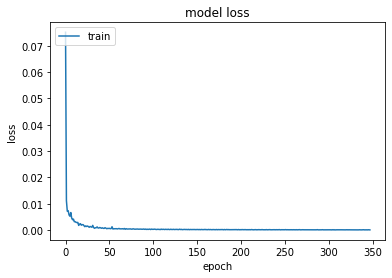

training done


In [3]:
# ####################single training single dataset####################################
if __name__ == '__main__':
    
    
    all_filenames = []
    trag_pos = 2
#     timesteps = 5
    experiment_index = 0
    
    while(experiment_index < 16):
        if(experiment_index == 0):
            timesteps = 5
        elif(experiment_index == 1):
            timesteps = 10
        elif(experiment_index == 2):
            timesteps = 20
        elif(experiment_index == 3):
            timesteps = 30
        elif(experiment_index == 4):
            timesteps = 40
        elif(experiment_index == 5):
            timesteps = 50
        elif(experiment_index == 6):
            timesteps = 60
        elif(experiment_index == 7):
            timesteps = 70
        elif(experiment_index == 8):
            timesteps = 80
        elif(experiment_index == 9):
            timesteps = 90
        elif(experiment_index == 10):
            timesteps = 100
        elif(experiment_index == 11):
            timesteps = 110
        elif(experiment_index == 12):
            timesteps = 120
        elif(experiment_index == 13):
            timesteps = 130
        elif(experiment_index == 14):
            timesteps = 140
        elif(experiment_index == 15):
            timesteps = 150
            
        experiment_index = experiment_index + 1
        
        
        filename = "datasets_full_trag/npz/Lstm-syn-dataset-fulltrag-addcoke/Lstm2_position.npz"
        data = np.load(filename)
        actions_val = None
        obs_val = None

        for key, value in data.items():
            if(key == "actions"):
                actions_val = value
            elif(key == "obs"):
                obs_val = value

        action_path = generate_csv(actions_val, "actions", "datasets_full_trag/actions/2_actions.csv")
        obs_path = generate_csv(obs_val, "obs", "datasets_full_trag/obs/2_obs.csv")
        print(action_path)
        print(obs_path)
        merge_csv(obs_path, action_path, "datasets_full_trag/merge/2_dataset.csv")
        train = readTrain("datasets_full_trag/merge/2_dataset.csv")
        

        #augment data
        aug_train = augDataRow(train, timesteps)
        print("~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~")

        # Normalization
        train_norm = normalize(aug_train)
        print(train_norm)
        print("~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~")

        X_train, Y_train = buildTrain_v2(train_norm, timesteps)


        print(X_train.shape)
        print(Y_train.shape)
        ### shuffle the data, and random seed is 10
#         X_train, Y_train = shuffle(X_train, Y_train)

    # # # #     # split training data and validation data
    # # # #     X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.2)


#         model = buildManyToOneModel(X_train)
#         model = buildManyToOneModel_expand_width(X_train)
        model = buildManyToOneModel_expand_depth_dropout_V2(X_train)
    
#         model.fit(X_train, Y_train, epochs=500, batch_size=64)
        callback = EarlyStopping(monitor="loss", patience=40, verbose=1, mode="auto")
        history = model.fit(X_train, Y_train, epochs=500, batch_size=64, callbacks=[callback])
        model.summary()
#         history = model.fit(X_train, Y_train, epochs=500, batch_size=64)

    
        plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper left')
        plt.legend(['train'], loc='upper left')

#         save_lossPic_path = "model_expand_depth/full_trag/512_256_64_ver/batch_size_128/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
#         save_lossPic_path = "model_expand_width/full_trag/1024_256_ver/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
#         save_lossPic_path = "model/full_trag/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
        save_lossPic_path = "model_expand_depth/full_trag/single_position/dropout_test/128_64_32_ver2/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"  
        plt.savefig(save_lossPic_path)
        
        plt.show()

#         save_path = "model_expand_depth/full_trag/512_256_64_ver/batch_size_128/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
#         save_path = "model_expand_width/full_trag/1024_256_ver/batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
#         save_path = "model/full_trag//batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
        save_path = "model_expand_depth/full_trag/single_position/dropout_test/128_64_32_ver2/batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"  

        model.save(save_path)  # creates a HDF5 file

    
        del model
    
    print("training done")



In [4]:
    #         callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=32, callbacks=[callback])
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=16, validation_data=(X_val, Y_val), callbacks=[callback])


In [5]:
# ###################single training many dataset####################################

# if __name__ == '__main__':
    
    
#     experiment_index = 0
    
#     while(experiment_index < 16):
#         if(experiment_index == 0):
#             timesteps = 5
#         elif(experiment_index == 1):
#             timesteps = 10
#         elif(experiment_index == 2):
#             timesteps = 20
#         elif(experiment_index == 3):
#             timesteps = 30
#         elif(experiment_index == 4):
#             timesteps = 40
#         elif(experiment_index == 5):
#             timesteps = 50
#         elif(experiment_index == 6):
#             timesteps = 60
#         elif(experiment_index == 7):
#             timesteps = 70
#         elif(experiment_index == 8):
#             timesteps = 80
#         elif(experiment_index == 9):
#             timesteps = 90
#         elif(experiment_index == 10):
#             timesteps = 100
#         elif(experiment_index == 11):
#             timesteps = 110
#         elif(experiment_index == 12):
#             timesteps = 120
#         elif(experiment_index == 13):
#             timesteps = 130
#         elif(experiment_index == 14):
#             timesteps = 140
#         elif(experiment_index == 15):
#             timesteps = 150
            
#         experiment_index = experiment_index + 1
        
        
#         filename_0 = "datasets_full_trag/merge/0_dataset.csv"
#         filename_1 = "datasets_full_trag/merge/1_dataset.csv"
#         filename_2 = "datasets_full_trag/merge/2_dataset.csv"
        
#         train0 = readTrain(filename_0)
#         train1 = readTrain(filename_1)
#         train2 = readTrain(filename_2)
        

#         #augment data
#         aug_train0 = augDataRow(train0, timesteps)
#         aug_train1 = augDataRow(train1, timesteps)
#         aug_train2 = augDataRow(train2, timesteps)
#         print("~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~")

#         hand_pos(aug_train0)
#         hand_pos(aug_train1)
#         hand_pos(aug_train2)
    
#     #     Normalization
#         train_0_norm = many_normalize(aug_train0)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         train_1_norm = many_normalize(aug_train1)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         train_2_norm = many_normalize(aug_train2)
        
#         print("~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~")

    
#         X0_train, Y0_train = buildTrain_v2(train_0_norm, timesteps)
#         X1_train, Y1_train = buildTrain_v2(train_1_norm, timesteps)
#         X2_train, Y2_train = buildTrain_v2(train_2_norm, timesteps)
        
        
            
#         print(type(X0_train))
#         print(X0_train.shape)
#         print(type(Y0_train))
#         print(Y0_train.shape)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print(type(X1_train))
#         print(X1_train.shape)
#         print(type(Y1_train))
#         print(Y1_train.shape)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print(type(X2_train))
#         print(X2_train.shape)
#         print(type(Y2_train))
#         print(Y2_train.shape)
    
#         X_train = np.concatenate((X0_train, X1_train), axis = 0)
#         X_train = np.concatenate((X_train, X2_train), axis = 0)

#         Y_train = np.concatenate((Y0_train, Y1_train), axis = 0)
#         Y_train = np.concatenate((Y_train, Y2_train), axis = 0)


#         print(X_train.shape)
#         print(Y_train.shape)
       


#         model = buildManyToOneModel_expand_depth_dropout(X_train)
    
#         callback = EarlyStopping(monitor="loss", patience=30, verbose=1, mode="auto")
# #         history = model.fit(X_train, Y_train, epochs=500, batch_size=128, callbacks=[callback])
#         history = model.fit(X_train, Y_train, epochs=500, batch_size=64)

    
#         plt.plot(history.history['loss'])
#         plt.title('model loss')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train'], loc='upper left')
        
#         trag_pos = "012"
        
#         save_lossPic_path = "model_expand_depth/full_trag/many_position/dropout_test/128_64_32_ver/batch_size_64/Loss/" + trag_pos + "_LstmFullTrag_" + str(timesteps) + ".png"  
#         plt.savefig(save_lossPic_path)
#         plt.show()

#         save_path = "model_expand_depth/full_trag/many_position/dropout_test/128_64_32_ver/batch_size_64/" + trag_pos + "_LstmFullTrag_" + str(timesteps) + ".h5"  
#         model.save(save_path)  # creates a HDF5 file

    
#         del model
    
#     print("training done")
    
    
